In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
import os
import glob
import re
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from scipy import stats

In [2]:
#Constant variables
month = {
                'Jan' : '01',
                'Feb' : '02',
                'Mar' : '03',
                'May' : '04',
                'Apr' : '05',
                'Jun' : '06',
                'Jul' : '07',
                'Aug' : '08',
                'Sep' : '09',
                'Oct' : '10',
                'Nov' : '11',
                'Dec' : '12',  
}

In [3]:
def format_date(date):
    if re.search('\w+ \d\d, \d\d\d\d',date):
        x = date.split(' ')
        x[0] = month[x[0]]
        x[1] = x[1][0] + x[1][1]
        date = x[2]+'-'+x[0]+'-'+x[1]
    return date

def change_trend_cal(df,suffix):
    percent_change = [0]
    trend = [0]
    for i in range(len(df)):
        if i > 0:
            pc = (df[df.columns[0]][i] - df[df.columns[0]][i-1])/df[df.columns[0]][i-1]*100
            percent_change.append(pc)
            trend.append(pc/abs(pc) if pc!=0 else 0)
    
    percent_change = pd.Series(percent_change, index=df.index)
    trend = pd.Series(trend, index=df.index)
    df['%Change'+suffix] = percent_change
    df['Trend'+suffix] = trend
    
def trend_error(forecast,forecast_suffix,actual,actual_suffix):
        diff = []
        for i in range(len(forecast)):
            diff.append(forecast['Trend'+forecast_suffix][i] == actual['Trend'+actual_suffix][i])
        return 100-sum(diff)/len(diff)*100    

# Use 2016-2019 Data to predict 2020's Gold Price

## import dataset

In [4]:
gold =pd.read_csv("./dataset/gld_price_data.csv")
gas =pd.read_csv("./dataset/natural_gas_data.csv")
oil = pd.read_csv('./dataset/crude_oil_eu_data.csv')
dolla = pd.read_csv('./dataset/dolla_index_data.csv')
etf = pd.read_csv('./dataset/etf_data.csv')
bond = pd.DataFrame(pd.read_csv('./dataset/bond_data.csv'),columns={'Date','Price'})
sil = pd.DataFrame(pd.read_csv('./dataset/silver_price_data.csv'), columns={'Date','USD'})
bit = pd.DataFrame(pd.read_csv('./dataset/bit_data.csv'), columns={'Date','Close'})

In [5]:
sil = sil[['Date','USD']]
bit = bit[['Date','Close']]
bond = bond[['Date','Price']]

In [6]:
d = []
for i in bond['Date']:
    d.append(format_date(i))
d = pd.Series(d)
bond['Date'] = d

## data preprocessing

In [7]:
### daily data only
### df : list of dataframe , name : list of dataframe's value's name , color : list of data's color
df = [gold,gas,oil,dolla,etf,bond,sil,bit]
columnName = ['gld_price', 'gas_price', 'oil_price','dolla_index','etf_index','bond_yield','silver_price','bitcoin_price']
color = ['red', 'green', 'blue', 'violet','purple','gray','silver','gold']

In [8]:
### rename all data columns
for i in range(len(df)):
    df[i] = df[i].rename(columns={df[i].columns[0]:'date',df[i].columns[1]:columnName[i]})

In [9]:
### set date as index and join all data
data = df[0].set_index('date')
for i in range(len(df)):
    if i > 0:
        data = data.join(df[i].set_index('date'))

In [10]:
data = data[1:]

In [11]:
data = data.replace('.', np.NaN)
data = data.dropna()

In [12]:
### convert index to datetime64
data = pd.DataFrame(data, index = np.array([np.datetime64(i) for i in data.index]))

In [13]:
### convert all data values to float
for i in data.columns:
    data[i] = data[i].astype(str).astype(float)

In [14]:
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm')

,gld_price,gas_price,oil_price,dolla_index,etf_index,bond_yield,silver_price,bitcoin_price
gld_price,1,-0.618284,-0.405689,0.506717,0.552617,-0.815483,0.649446,0.54993
gas_price,-0.618284,1,0.439112,-0.338013,-0.506168,0.685286,-0.241628,-0.233532
oil_price,-0.405689,0.439112,1,-0.379612,-0.737112,0.75894,-0.335208,0.306595
dolla_index,0.506717,-0.338013,-0.379612,1,0.499,-0.515272,0.0451954,0.136418
etf_index,0.552617,-0.506168,-0.737112,0.499,1,-0.72687,0.322043,0.00792396
bond_yield,-0.815483,0.685286,0.75894,-0.515272,-0.72687,1,-0.580006,-0.15045
silver_price,0.649446,-0.241628,-0.335208,0.0451954,0.322043,-0.580006,1,0.136656
bitcoin_price,0.54993,-0.233532,0.306595,0.136418,0.00792396,-0.15045,0.136656,1


In [15]:
## drop unusable  feature
data = data.drop(columns=[data.columns[i] for i in [1,7]])

In [16]:
data

,gld_price,oil_price,dolla_index,etf_index,bond_yield,silver_price
2016-03-01,1236.50,35.73,113.9208,21.97,1.827,14.990
2016-03-02,1239.20,36.38,113.7902,22.00,1.835,14.820
2016-03-03,1250.25,35.75,113.2419,23.51,1.835,14.970
2016-03-04,1277.50,37.61,112.6317,22.31,1.876,15.430
2016-03-07,1267.90,39.02,112.6166,22.08,1.904,15.660
2016-03-09,1246.40,40.26,112.4212,22.31,1.879,15.270
2016-03-10,1266.50,38.63,112.4122,23.14,1.936,15.270
2016-03-11,1264.75,39.41,111.7351,21.90,1.980,15.500
2016-03-14,1242.75,38.06,112.1613,21.14,1.961,15.600
2016-03-15,1232.00,37.49,112.5466,19.70,1.968,15.320


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1069 entries, 2016-03-01 to 2020-09-28
Data columns (total 6 columns):
gld_price       1069 non-null float64
oil_price       1069 non-null float64
dolla_index     1069 non-null float64
etf_index       1069 non-null float64
bond_yield      1069 non-null float64
silver_price    1069 non-null float64
dtypes: float64(6)
memory usage: 58.5 KB


In [18]:
data.describe()

,gld_price,oil_price,dolla_index,etf_index,bond_yield,silver_price
count,1069.000000,1069.000000,1069.000000,1069.000000,1069.000000,1069.000000
mean,1369.600982,56.574546,114.285441,14.702442,2.087738,17.073068
std,189.177360,12.915082,3.556798,5.004134,0.697228,2.385096
min,1125.700000,9.120000,106.490700,8.880000,0.512000,12.005000
25%,1250.450000,47.310000,111.763900,11.380000,1.702000,15.705000
50%,1297.250000,57.130000,114.560700,13.020000,2.235000,16.860000
75%,1459.650000,65.670000,116.457800,16.620000,2.618000,17.690000
max,2067.150000,86.070000,126.471900,48.980000,3.239000,28.885000


In [19]:
x = data.drop(columns=[data.columns[i] for i in [0]])
y = data.drop(columns=[data.columns[i] for i in [1,2,3,4,5]])

In [20]:
x

,oil_price,dolla_index,etf_index,bond_yield,silver_price
2016-03-01,35.73,113.9208,21.97,1.827,14.990
2016-03-02,36.38,113.7902,22.00,1.835,14.820
2016-03-03,35.75,113.2419,23.51,1.835,14.970
2016-03-04,37.61,112.6317,22.31,1.876,15.430
2016-03-07,39.02,112.6166,22.08,1.904,15.660
2016-03-09,40.26,112.4212,22.31,1.879,15.270
2016-03-10,38.63,112.4122,23.14,1.936,15.270
2016-03-11,39.41,111.7351,21.90,1.980,15.500
2016-03-14,38.06,112.1613,21.14,1.961,15.600
2016-03-15,37.49,112.5466,19.70,1.968,15.320


In [21]:
y

,gld_price
2016-03-01,1236.50
2016-03-02,1239.20
2016-03-03,1250.25
2016-03-04,1277.50
2016-03-07,1267.90
2016-03-09,1246.40
2016-03-10,1266.50
2016-03-11,1264.75
2016-03-14,1242.75
2016-03-15,1232.00


In [22]:
x_train = x[x.index < '2020-01-01']
x_test = x[x.index >= '2020-01-01']
y_train = y[y.index < '2020-01-01']
y_test = y[y.index >= '2020-01-01']

In [23]:
x_train

,oil_price,dolla_index,etf_index,bond_yield,silver_price
2016-03-01,35.73,113.9208,21.97,1.827,14.990
2016-03-02,36.38,113.7902,22.00,1.835,14.820
2016-03-03,35.75,113.2419,23.51,1.835,14.970
2016-03-04,37.61,112.6317,22.31,1.876,15.430
2016-03-07,39.02,112.6166,22.08,1.904,15.660
2016-03-09,40.26,112.4212,22.31,1.879,15.270
2016-03-10,38.63,112.4122,23.14,1.936,15.270
2016-03-11,39.41,111.7351,21.90,1.980,15.500
2016-03-14,38.06,112.1613,21.14,1.961,15.600
2016-03-15,37.49,112.5466,19.70,1.968,15.320


In [24]:
x_test.tail(10)

,oil_price,dolla_index,etf_index,bond_yield,silver_price
2020-09-15,39.54,115.9435,20.32,0.680,27.545
2020-09-16,41.23,115.6920,20.08,0.698,27.380
2020-09-17,42.35,115.7819,19.95,0.689,26.745
2020-09-18,42.16,115.5932,20.22,0.697,27.060
2020-09-21,40.37,116.7602,21.60,0.669,26.360
2020-09-22,40.84,116.9191,21.63,0.671,24.300
2020-09-23,41.09,117.6486,23.43,0.677,23.595
2020-09-24,41.24,117.9406,23.41,0.668,22.220
2020-09-25,40.91,118.2650,22.09,0.656,22.630
2020-09-28,41.59,118.0243,22.01,0.658,22.890


In [25]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.8,max_depth = 2, alpha = 1,n_estimators = 200)
# xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.3, max_depth=6,alpha=0,)

In [26]:
xg_reg.fit(x_train,y_train)
preds = xg_reg.predict(x_test)

[21:01:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


In [27]:
preds

array([1515.9916, 1502.8739, 1465.909 , 1470.004 , 1491.4388, 1486.7516,
       1488.9729, 1450.6188, 1474.9398, 1464.1162, 1478.9402, 1462.8984,
       1456.7006, 1479.201 , 1476.2179, 1523.9928, 1528.5194, 1531.6041,
       1556.1017, 1532.7985, 1523.2853, 1463.6208, 1450.8439, 1469.8339,
       1466.8743, 1415.8075, 1434.3268, 1394.4069, 1470.8258, 1493.599 ,
       1499.7151, 1519.4314, 1561.5088, 1545.0319, 1573.4359, 1494.4497,
       1451.6877, 1448.6483, 1433.693 , 1436.8552, 1383.7621, 1422.3593,
       1390.7932, 1395.1998, 1427.514 , 1471.4266, 1462.6943, 1423.0781,
       1424.8215, 1396.2325, 1298.4517, 1298.4517, 1298.4517, 1298.4517,
       1298.4517, 1298.4517, 1298.4517, 1298.4517, 1311.9951, 1324.8623,
       1298.4517, 1298.4517, 1298.4517, 1318.3069, 1320.9849, 1376.2904,
       1376.2904, 1396.2325, 1396.2325, 1371.8712, 1350.6514, 1330.0485,
       1363.9137, 1388.7024, 1371.8712, 1330.0485, 1354.6357, 1376.2904,
       1350.6514, 1330.4144, 1351.201 , 1396.2325, 

In [28]:
pred = pd.DataFrame(preds, columns=['gld_price_forecast'],index = y_test.index)

In [29]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

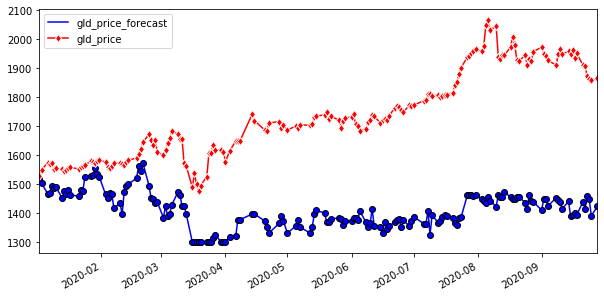

In [30]:
ax = plt.gca()
pred.plot(kind='line', y='gld_price_forecast',ax=ax,color='blue',figsize=(10,5),marker='o',markeredgecolor="black")
y_test.plot(kind='line', y='gld_price',ax=ax,color='red',marker='d',markeredgecolor="white")
plt.show()

In [31]:
print('Forecast Accuracy of: gld_price')
accuracy_prod = forecast_accuracy(pred['gld_price_forecast'].values, y_test['gld_price'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

Forecast Accuracy of: gld_price
mape :  0.1811
me :  -324.625
mae :  324.625
mpe :  -0.1811
rmse :  361.6241
corr :  0.0384
minmax :  0.1811


# Use 01/03/2016-31/02/2021 Data to Predict 01/03/2021-08/03/2021

In [32]:
df2 = []
path = './new dataset/'
os.chdir(path)
for file in glob.glob("*.csv"):
    df2.append(pd.read_csv(file))
    print(file)
os.chdir('../')

Crude Oil Prices Brent - Europe (1_3_2016-8_3_2021).csv
ETFS Physical Gold Futures Historical Data (1_3_2016 - 8_3_2021).csv
GOLDAMGBD228NLBM (1_3_2016 - 8_3_2021).csv
Henry Hub Natural Gas Spot Price (7_1_1997 - 8_3_2021).csv
Silver Futures Historical Data (1_3_2016 - 8_3_2021).csv
United States 10-Year Bond Yield Historical Data (1_3_2016 - 8_3_2021).csv
US Dollar Index Historical Data (1_3_2016 - 8_3_2021).csv


In [33]:
### rename all data columns
data = []
columnName = ['Crude_Oil', 'Gold_ETFS','gld_price', 'Natural_Gas','Silver','Bond_Yield','USDollar_Index']
for i in range(len(df2)):
    data.append(pd.DataFrame(df2[i], columns={df2[i].columns[0],df2[i].columns[1]}))

In [34]:
data[0] = data[0][['DATE','DCOILBRENTEU']]
data[1] = data[1][['Date','Price']]
data[2] = data[2][['DATE','GOLDAMGBD228NLBM']]
data[3] = data[3][['Day','Henry Hub Natural Gas Spot Price Dollars per Million Btu']]
data[4] = data[4][['Date','Price']]
data[5] = data[5][['Date','Price']]
data[6] = data[6][['Date','Price']]

In [35]:
for i in range(len(df2)):
    data[i] = data[i].rename(columns={data[i].columns[0]:'date',data[i].columns[1]:columnName[i]})

In [36]:
for i in [1,4,5,6]:
    d = []
    for j in data[i]['date']:
        d.append(format_date(j))
    d = pd.Series(d)
    data[i]['date'] = d

In [37]:
tmp = data[2].set_index('date')
for i in range(len(data)):
    if i != 2:
        tmp = tmp.join(data[i].set_index('date'))
data = tmp.copy()

In [38]:
data = data.replace('.', np.NaN)
data = data.dropna()

In [39]:
### convert index to datetime64
data = pd.DataFrame(data, index = np.array([np.datetime64(i) for i in data.index]))

In [40]:
### convert all data values to float
for i in data.columns:
    data[i] = data[i].astype(str).astype(float)

In [41]:
z_scores = stats.zscore(data)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
data = data[filtered_entries]

## Correlation

In [42]:
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm')

,gld_price,Crude_Oil,Gold_ETFS,Natural_Gas,Silver,Bond_Yield,USDollar_Index
gld_price,1,-0.401372,0.99793,-0.50196,0.728798,-0.841937,-0.284992
Crude_Oil,-0.401372,1,-0.414919,0.412359,-0.36827,0.73266,-0.188333
Gold_ETFS,0.99793,-0.414919,1,-0.505693,0.738432,-0.850269,-0.287657
Natural_Gas,-0.50196,0.412359,-0.505693,1,-0.13508,0.621973,-0.0487455
Silver,0.728798,-0.36827,0.738432,-0.13508,1,-0.635751,-0.417365
Bond_Yield,-0.841937,0.73266,-0.850269,0.621973,-0.635751,1,0.0309253
USDollar_Index,-0.284992,-0.188333,-0.287657,-0.0487455,-0.417365,0.0309253,1


In [43]:
## drop unusable  feature
data = data.drop(columns=[data.columns[i] for i in [1,6]])

In [44]:
data

,gld_price,Gold_ETFS,Natural_Gas,Silver,Bond_Yield
2016-03-01,1240.00,119.09,1.57,15.562,1.827
2016-03-02,1229.35,119.61,1.60,15.850,1.835
2016-03-03,1241.95,121.58,1.59,15.976,1.835
2016-03-04,1271.50,123.02,1.49,16.536,1.876
2016-03-07,1267.60,122.43,1.56,16.484,1.904
2016-03-08,1274.10,122.52,1.60,16.225,1.831
2016-03-09,1258.25,121.33,1.61,16.206,1.879
2016-03-10,1247.25,122.25,1.72,16.398,1.936
2016-03-11,1262.25,121.79,1.74,16.465,1.980
2016-03-14,1256.55,120.11,1.68,16.381,1.961


In [45]:
x = data.drop(columns=[data.columns[i] for i in [0]])
y = data.drop(columns=[data.columns[i] for i in range(1,len(data.columns))])

In [46]:
min_max_scaler = preprocessing.MinMaxScaler()
scale = min_max_scaler.fit_transform(x)
temp = pd.DataFrame(scale, columns=x.columns, index = data.index)
x = temp

In [47]:
x_train = x[x.index < '2021-03-01']
x_test = x[x.index >= '2021-03-01']
y_train = y[y.index < '2021-03-01']
y_test = y[y.index >= '2021-03-01']

In [48]:
x_train.head(5)

,Gold_ETFS,Natural_Gas,Silver,Bond_Yield
2016-03-01,0.121142,0.058111,0.233021,0.482215
2016-03-02,0.127199,0.065375,0.250884,0.485149
2016-03-03,0.150146,0.062954,0.258699,0.485149
2016-03-04,0.166919,0.038741,0.293432,0.500183
2016-03-07,0.160047,0.055690,0.290207,0.510451


In [49]:
y_train.head(5)

,gld_price
2016-03-01,1240.00
2016-03-02,1229.35
2016-03-03,1241.95
2016-03-04,1271.50
2016-03-07,1267.60


In [50]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.8,max_depth = 2, alpha = 1, n_estimators = 200)


In [51]:
xg_reg.fit(x_train,y_train)
preds = xg_reg.predict(x_test)

[21:01:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


In [52]:
pred = pd.DataFrame(preds, columns=['gld_price_forecast'],index = y_test.index)

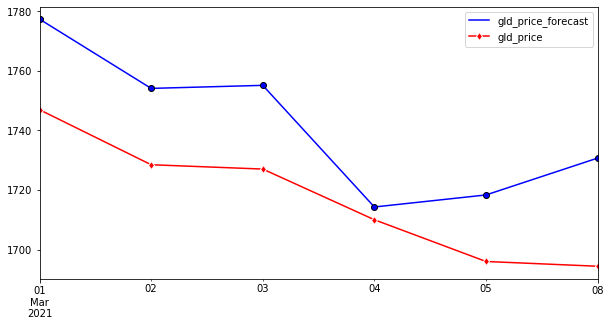

In [53]:
ax = plt.gca()
pred.plot(kind='line', y='gld_price_forecast',ax=ax,color='blue',figsize=(10,5),marker='o',markeredgecolor="black")
y_test.plot(kind='line', y='gld_price',ax=ax,color='red',marker='d',markeredgecolor="white")
plt.show()

In [54]:
print('Forecast Accuracy of: gld_price')
accuracy_prod = forecast_accuracy(pred['gld_price_forecast'].values, y_test['gld_price'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

Forecast Accuracy of: gld_price
mape :  0.0143
me :  24.4919
mae :  24.4919
mpe :  0.0143
rmse :  26.4583
corr :  0.8968
minmax :  0.014


# Use 2016-2019 Data to predict 2020's Gold Price (Classification)

In [55]:
df2 = []
path = './dataset/'
os.chdir(path)
for file in glob.glob("*.csv"):
    df2.append(pd.read_csv(file))
    print(file)
os.chdir('../')

bit_data.csv
bond_data.csv
crude_oil_eu_data.csv
dolla_index_data.csv
ETF_data.csv
gld_price_data.csv
gold_demand_data.csv
natural_gas_data.csv
silver_price_data.csv


In [56]:
df2[0] = df2[0][['Date','Close']]
df2[1] = df2[1][['Date','Price']]
df2[8] = df2[8][['Date','USD']]

In [57]:
d = []
for i in df2[1]['Date']:
    d.append(format_date(i))
d = pd.Series(d)
df2[1]['Date'] = d

In [58]:
### daily data only
### df : list of dataframe , name : list of dataframe's value's name , color : list of data's color
df = [gold,gas,oil,dolla,etf,bond,sil,bit]
columnName = ['gld_price', 'gas_price', 'oil_price','dolla_index','etf_index','bond_yield','silver_price','bitcoin_price']
color = ['red', 'green', 'blue', 'violet','purple','gray','silver','gold']

In [59]:
### rename all data columns
for i in range(len(df)):
    df[i] = df[i].rename(columns={df[i].columns[0]:'date',df[i].columns[1]:columnName[i]})

In [60]:
### set date as index and join all data
data = df[0].set_index('date')
for i in range(len(df)):
    if i > 0:
        data = data.join(df[i].set_index('date'))
data = data[1:]
data = data.replace('.', np.NaN)
data = data.dropna()

In [61]:
### convert index to datetime64
data = pd.DataFrame(data, index = np.array([np.datetime64(i) for i in data.index]))

In [62]:
### convert all data values to float
for i in data.columns:
    data[i] = data[i].astype(str).astype(float)

In [63]:
## drop unusable  feature
data = data.drop(columns=[data.columns[i] for i in [1,7]])

In [64]:
x = data.drop(columns=[data.columns[i] for i in [0]])
y = data.drop(columns=[data.columns[i] for i in [1,2,3,4,5]])

In [65]:
change_trend_cal(y,'_xg')

In [66]:
y

,gld_price,%Change_xg,Trend_xg
2016-03-01,1236.50,0.000000,0.0
2016-03-02,1239.20,0.218358,1.0
2016-03-03,1250.25,0.891704,1.0
2016-03-04,1277.50,2.179564,1.0
2016-03-07,1267.90,-0.751468,-1.0
2016-03-09,1246.40,-1.695717,-1.0
2016-03-10,1266.50,1.612644,1.0
2016-03-11,1264.75,-0.138176,-1.0
2016-03-14,1242.75,-1.739474,-1.0
2016-03-15,1232.00,-0.865017,-1.0


In [67]:
y = pd.DataFrame(y, columns = ['Trend_xg'] )

In [68]:
y

,Trend_xg
2016-03-01,0.0
2016-03-02,1.0
2016-03-03,1.0
2016-03-04,1.0
2016-03-07,-1.0
2016-03-09,-1.0
2016-03-10,1.0
2016-03-11,-1.0
2016-03-14,-1.0
2016-03-15,-1.0


In [69]:
x_train = x[x.index < '2020-01-01']
x_test = x[x.index >= '2020-01-01']
y_train = y[y.index < '2020-01-01']
y_test = y[y.index >= '2020-01-01']

In [70]:
xg_csf = xgb.XGBClassifier(objective='binary:logistic', max_depth=2, learning_rate=0.8, n_estimators=200 , booster='gbtree')

In [71]:
xg_reg.fit(x_train,y_train)
preds = xg_reg.predict(x_test)

[21:01:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


In [72]:
preds

array([ 0.17317356, -0.02913791,  0.36982796, -0.11029094, -0.5367491 ,
       -0.10335693,  0.07154062, -0.27017617, -0.1062031 ,  1.1631567 ,
        0.24893656, -0.07162067,  0.36228883,  0.2828971 ,  0.4680488 ,
        0.19611631,  0.842883  ,  0.32157892,  0.6000357 ,  0.06567132,
        0.21005811,  0.8503835 ,  0.22590533,  0.01014568,  0.442254  ,
        0.6874284 , -0.79467213,  0.6111278 ,  0.06611026, -0.2232227 ,
        1.0073372 , -0.67465484, -0.48670983,  1.0221695 , -0.02444787,
       -0.26588145, -0.03111146,  0.0302671 , -1.3686113 , -0.18008155,
        0.09438272, -0.54858863, -0.21487674,  0.23529366,  0.25389835,
        0.04227874,  0.63862675,  1.0702302 ,  1.0021359 ,  0.72235096,
        1.1449283 ,  1.1449283 ,  1.1449283 ,  1.1449283 ,  1.1449283 ,
        1.1449283 ,  1.1449283 ,  1.1449283 ,  0.7886351 ,  0.7886351 ,
        1.0376992 ,  1.1449283 ,  1.0376992 ,  0.7886351 ,  1.2003586 ,
        0.6358827 ,  0.5256774 ,  1.0153143 ,  0.8607926 ,  0.89

In [73]:
preds = [1 if i>0 else -1 if i<0 else 0 for i in preds]

In [74]:
pred = pd.DataFrame(preds, columns=['Trend_xg_forecast'],index = y_test.index)

In [75]:
print(f"xGB Trend Error (%) : {trend_error(pred, '_xg_forecast',y_test,'_xg')}")

xGB Trend Error (%) : 46.24277456647399
